<a href="https://colab.research.google.com/github/tusharkanta/ML_DL/blob/eva/S6/S6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

Target:

Kept the model same as previous as the parameters has hit 9904. Reduced batch size from 32 to 24, changed learning rate from 0.01 to 0.008 and changed random roation param back to -7,7. Result: Parameters: 9,904 Best Train Accuracy: 98.86 Best Test Accuracy: 99.42 Analysis: Validation accuracy has improved and remained quite consistent (does not fluctuate rapidly)

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [9]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=16)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

# How did we get those mean and std values which we used above?

Let's run a small experiment

In [10]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1305)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


# The model
Let's start with the model we first saw

In [0]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26*26*16 RF=3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24*24*16  RF=5

        # TRANSITION BLOCK 1
         # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24*24*8  RF=5
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12*12*8  RF=6
        

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10*10*16  RF=10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 8*8*16  RF=14
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=24, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(24),
            nn.Dropout(dropout_value)
        ) # output_size = 6*6*24  RF=18
        #self.convblock7 = nn.Sequential(
         #   nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
          #  nn.ReLU(),            
           # nn.BatchNorm2d(16),
            #nn.Dropout(dropout_value)
        #) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1*1*24  RF=28

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=24, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        ) # output_size = 1*1*10  RF=28


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        #x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [12]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
          Dropout-14           [-1

In [0]:
from tqdm import tqdm
import numpy as np

train_losses_normal = []
test_losses_normal = []
train_acc_normal = []
test_acc_normal = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    
    train_losses_normal.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Accuracy={100*correct/processed:0.2f}')
    train_acc_normal.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses_normal.append(test_loss)

    print('\nTest set: Avg loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_normal.append(100. * correct / len(test_loader.dataset))

In [14]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.008, momentum=0.9)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.1093, Accuracy: 9706/10000 (97.06%)

EPOCH: 1


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0750, Accuracy: 9776/10000 (97.76%)

EPOCH: 2


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0447, Accuracy: 9878/10000 (98.78%)

EPOCH: 3


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0426, Accuracy: 9870/10000 (98.70%)

EPOCH: 4


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0341, Accuracy: 9892/10000 (98.92%)

EPOCH: 5


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0306, Accuracy: 9903/10000 (99.03%)

EPOCH: 6


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0347, Accuracy: 9882/10000 (98.82%)

EPOCH: 7


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0264, Accuracy: 9917/10000 (99.17%)

EPOCH: 8


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0254, Accuracy: 9919/10000 (99.19%)

EPOCH: 9


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0261, Accuracy: 9918/10000 (99.18%)

EPOCH: 10


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0251, Accuracy: 9923/10000 (99.23%)

EPOCH: 11


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0253, Accuracy: 9924/10000 (99.24%)

EPOCH: 12


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0235, Accuracy: 9926/10000 (99.26%)

EPOCH: 13


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0222, Accuracy: 9928/10000 (99.28%)

EPOCH: 14


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0256, Accuracy: 9914/10000 (99.14%)

EPOCH: 15


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0221, Accuracy: 9930/10000 (99.30%)

EPOCH: 16


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0255, Accuracy: 9925/10000 (99.25%)

EPOCH: 17


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0217, Accuracy: 9930/10000 (99.30%)

EPOCH: 18


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0212, Accuracy: 9930/10000 (99.30%)

EPOCH: 19


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0203, Accuracy: 9940/10000 (99.40%)

EPOCH: 20


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0204, Accuracy: 9933/10000 (99.33%)

EPOCH: 21


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0202, Accuracy: 9931/10000 (99.31%)

EPOCH: 22


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0184, Accuracy: 9939/10000 (99.39%)

EPOCH: 23


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0182, Accuracy: 9942/10000 (99.42%)

EPOCH: 24


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0190, Accuracy: 9936/10000 (99.36%)

EPOCH: 25


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0205, Accuracy: 9934/10000 (99.34%)

EPOCH: 26


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0201, Accuracy: 9931/10000 (99.31%)

EPOCH: 27


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0196, Accuracy: 9936/10000 (99.36%)

EPOCH: 28


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0195, Accuracy: 9940/10000 (99.40%)

EPOCH: 29


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0174, Accuracy: 9943/10000 (99.43%)

EPOCH: 30


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0185, Accuracy: 9935/10000 (99.35%)

EPOCH: 31


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0182, Accuracy: 9935/10000 (99.35%)

EPOCH: 32


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0183, Accuracy: 9942/10000 (99.42%)

EPOCH: 33


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0183, Accuracy: 9938/10000 (99.38%)

EPOCH: 34


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0179, Accuracy: 9940/10000 (99.40%)

EPOCH: 35


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0199, Accuracy: 9934/10000 (99.34%)

EPOCH: 36


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0187, Accuracy: 9938/10000 (99.38%)

EPOCH: 37


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0174, Accuracy: 9947/10000 (99.47%)

EPOCH: 38


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0165, Accuracy: 9948/10000 (99.48%)

EPOCH: 39


Loss=0.013151903636753559 Accuracy=99.23: 100%|██████████| 469/469 [00:12<00:00, 38.23it/s]



Test set: Avg loss: 0.0191, Accuracy: 9943/10000 (99.43%)



# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments. 

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm
import numpy as np

train_losses_l1 = []
test_losses_l1 = []
train_acc_l1 = []
test_acc_l1 = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    #xx = nn.Parameter(torch.from_numpy(np.ones((3,3))))
    #target1 = torch.from_numpy(np.zeros((3,3,16))).to(device)
    #l1_crit = nn.L1Loss()
    #l1_crit(xx, target)
    #l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0
    for param in model.parameters():
        reg_loss += torch.sum(abs(param))
        #if param.dim() > 1:
          #lam * param.norm(1)
          #reg_loss += param.norm(1)

    factor = 0.0001
    loss += factor * reg_loss
    train_losses_l1.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Accuracy={100*correct/processed:0.2f}')
    train_acc_l1.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses_l1.append(test_loss)

    print('\nTest set: Avg loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_l1.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [16]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.008, momentum=0.9)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.1021, Accuracy: 9727/10000 (97.27%)

EPOCH: 1


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0632, Accuracy: 9821/10000 (98.21%)

EPOCH: 2


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0414, Accuracy: 9877/10000 (98.77%)

EPOCH: 3


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0373, Accuracy: 9886/10000 (98.86%)

EPOCH: 4


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0369, Accuracy: 9879/10000 (98.79%)

EPOCH: 5


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0319, Accuracy: 9884/10000 (98.84%)

EPOCH: 6


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0302, Accuracy: 9897/10000 (98.97%)

EPOCH: 7


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0280, Accuracy: 9899/10000 (98.99%)

EPOCH: 8


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0255, Accuracy: 9919/10000 (99.19%)

EPOCH: 9


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0325, Accuracy: 9889/10000 (98.89%)

EPOCH: 10


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0260, Accuracy: 9906/10000 (99.06%)

EPOCH: 11


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0326, Accuracy: 9884/10000 (98.84%)

EPOCH: 12


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0275, Accuracy: 9907/10000 (99.07%)

EPOCH: 13


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0265, Accuracy: 9922/10000 (99.22%)

EPOCH: 14


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0268, Accuracy: 9913/10000 (99.13%)

EPOCH: 15


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0241, Accuracy: 9921/10000 (99.21%)

EPOCH: 16


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0271, Accuracy: 9907/10000 (99.07%)

EPOCH: 17


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0308, Accuracy: 9890/10000 (98.90%)

EPOCH: 18


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0240, Accuracy: 9922/10000 (99.22%)

EPOCH: 19


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0245, Accuracy: 9917/10000 (99.17%)

EPOCH: 20


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0249, Accuracy: 9926/10000 (99.26%)

EPOCH: 21


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0244, Accuracy: 9923/10000 (99.23%)

EPOCH: 22


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0241, Accuracy: 9922/10000 (99.22%)

EPOCH: 23


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0247, Accuracy: 9925/10000 (99.25%)

EPOCH: 24


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0207, Accuracy: 9941/10000 (99.41%)

EPOCH: 25


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0221, Accuracy: 9935/10000 (99.35%)

EPOCH: 26


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0241, Accuracy: 9924/10000 (99.24%)

EPOCH: 27


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0249, Accuracy: 9911/10000 (99.11%)

EPOCH: 28


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0252, Accuracy: 9915/10000 (99.15%)

EPOCH: 29


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0208, Accuracy: 9933/10000 (99.33%)

EPOCH: 30


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0255, Accuracy: 9921/10000 (99.21%)

EPOCH: 31


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0219, Accuracy: 9925/10000 (99.25%)

EPOCH: 32


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0246, Accuracy: 9924/10000 (99.24%)

EPOCH: 33


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0259, Accuracy: 9918/10000 (99.18%)

EPOCH: 34


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0239, Accuracy: 9916/10000 (99.16%)

EPOCH: 35


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0208, Accuracy: 9934/10000 (99.34%)

EPOCH: 36


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0203, Accuracy: 9939/10000 (99.39%)

EPOCH: 37


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0221, Accuracy: 9921/10000 (99.21%)

EPOCH: 38


  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0254, Accuracy: 9916/10000 (99.16%)

EPOCH: 39


Loss=0.11989995092153549 Accuracy=98.92: 100%|██████████| 469/469 [00:13<00:00, 35.90it/s]



Test set: Avg loss: 0.0181, Accuracy: 9943/10000 (99.43%)



In [0]:
from tqdm import tqdm
import numpy as np

train_losses_l2 = []
test_losses_l2 = []
train_acc_l2 = []
test_acc_l2 = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)

    train_losses_l2.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc_l2.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    wrong_class_images=[]
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            

    test_loss /= len(test_loader.dataset)
    test_losses_l2.append(test_loss)

    print('\nTest set: Avg loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_l2.append(100. * correct / len(test_loader.dataset))

In [18]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.008, momentum=0.9, weight_decay=0.0001)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.09561777114868164 Batch_id=468 Accuracy=85.69: 100%|██████████| 469/469 [00:12<00:00, 38.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.2500, Accuracy: 9238/10000 (92.38%)

EPOCH: 1


Loss=0.04531943425536156 Batch_id=468 Accuracy=97.07: 100%|██████████| 469/469 [00:12<00:00, 36.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0663, Accuracy: 9804/10000 (98.04%)

EPOCH: 2


Loss=0.08037713170051575 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:12<00:00, 37.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0562, Accuracy: 9846/10000 (98.46%)

EPOCH: 3


Loss=0.02674666978418827 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:12<00:00, 46.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0628, Accuracy: 9817/10000 (98.17%)

EPOCH: 4


Loss=0.06382583826780319 Batch_id=468 Accuracy=98.27: 100%|██████████| 469/469 [00:11<00:00, 39.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0397, Accuracy: 9891/10000 (98.91%)

EPOCH: 5


Loss=0.1045452132821083 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:11<00:00, 45.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0382, Accuracy: 9887/10000 (98.87%)

EPOCH: 6


Loss=0.04953046143054962 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:12<00:00, 39.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0372, Accuracy: 9885/10000 (98.85%)

EPOCH: 7


Loss=0.05843029543757439 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:12<00:00, 43.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0315, Accuracy: 9900/10000 (99.00%)

EPOCH: 8


Loss=0.057593267410993576 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:12<00:00, 38.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0342, Accuracy: 9897/10000 (98.97%)

EPOCH: 9


Loss=0.08477655798196793 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:11<00:00, 39.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0343, Accuracy: 9897/10000 (98.97%)

EPOCH: 10


Loss=0.013662208802998066 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:12<00:00, 38.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0308, Accuracy: 9902/10000 (99.02%)

EPOCH: 11


Loss=0.05974092707037926 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:12<00:00, 38.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0313, Accuracy: 9897/10000 (98.97%)

EPOCH: 12


Loss=0.032379377633333206 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:12<00:00, 38.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0324, Accuracy: 9902/10000 (99.02%)

EPOCH: 13


Loss=0.033630531281232834 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:12<00:00, 38.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0283, Accuracy: 9910/10000 (99.10%)

EPOCH: 14


Loss=0.014581789262592793 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:12<00:00, 37.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0283, Accuracy: 9910/10000 (99.10%)

EPOCH: 15


Loss=0.014587040059268475 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:12<00:00, 38.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0279, Accuracy: 9915/10000 (99.15%)

EPOCH: 16


Loss=0.007270639296621084 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:12<00:00, 37.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0263, Accuracy: 9923/10000 (99.23%)

EPOCH: 17


Loss=0.0241019818931818 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:12<00:00, 45.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0267, Accuracy: 9912/10000 (99.12%)

EPOCH: 18


Loss=0.020301729440689087 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:12<00:00, 38.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0260, Accuracy: 9923/10000 (99.23%)

EPOCH: 19


Loss=0.019457921385765076 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:12<00:00, 36.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0277, Accuracy: 9916/10000 (99.16%)

EPOCH: 20


Loss=0.039283983409404755 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:12<00:00, 37.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0271, Accuracy: 9923/10000 (99.23%)

EPOCH: 21


Loss=0.09378242492675781 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:12<00:00, 36.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0248, Accuracy: 9921/10000 (99.21%)

EPOCH: 22


Loss=0.061968881636857986 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:12<00:00, 38.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0265, Accuracy: 9908/10000 (99.08%)

EPOCH: 23


Loss=0.0679510161280632 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:12<00:00, 36.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0264, Accuracy: 9918/10000 (99.18%)

EPOCH: 24


Loss=0.010742053389549255 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:12<00:00, 36.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0248, Accuracy: 9917/10000 (99.17%)

EPOCH: 25


Loss=0.01617804728448391 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:13<00:00, 35.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0267, Accuracy: 9911/10000 (99.11%)

EPOCH: 26


Loss=0.047126155346632004 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:12<00:00, 37.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0254, Accuracy: 9918/10000 (99.18%)

EPOCH: 27


Loss=0.0040097832679748535 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:12<00:00, 36.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0259, Accuracy: 9913/10000 (99.13%)

EPOCH: 28


Loss=0.01749347150325775 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:12<00:00, 36.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0242, Accuracy: 9920/10000 (99.20%)

EPOCH: 29


Loss=0.026825526729226112 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:12<00:00, 37.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0242, Accuracy: 9923/10000 (99.23%)

EPOCH: 30


Loss=0.029300697147846222 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:12<00:00, 38.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0211, Accuracy: 9931/10000 (99.31%)

EPOCH: 31


Loss=0.0329931266605854 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:12<00:00, 38.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0260, Accuracy: 9909/10000 (99.09%)

EPOCH: 32


Loss=0.037151020020246506 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:12<00:00, 38.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0217, Accuracy: 9926/10000 (99.26%)

EPOCH: 33


Loss=0.007681066635996103 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:12<00:00, 38.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0242, Accuracy: 9912/10000 (99.12%)

EPOCH: 34


Loss=0.040603574365377426 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:12<00:00, 38.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0261, Accuracy: 9910/10000 (99.10%)

EPOCH: 35


Loss=0.02747703157365322 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:11<00:00, 39.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0217, Accuracy: 9935/10000 (99.35%)

EPOCH: 36


Loss=0.06929884105920792 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:12<00:00, 37.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0230, Accuracy: 9925/10000 (99.25%)

EPOCH: 37


Loss=0.03853459283709526 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:12<00:00, 38.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0252, Accuracy: 9916/10000 (99.16%)

EPOCH: 38


Loss=0.008044962771236897 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:12<00:00, 38.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0218, Accuracy: 9931/10000 (99.31%)

EPOCH: 39


Loss=0.04013790190219879 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:12<00:00, 39.07it/s]



Test set: Avg loss: 0.0216, Accuracy: 9928/10000 (99.28%)



In [0]:
from tqdm import tqdm
import numpy as np

train_losses_l1l2 = []
test_losses_l1l2 = []
train_acc_l1l2 = []
test_acc_l1l2 = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    #xx = nn.Parameter(torch.from_numpy(np.ones((3,3))))
    #target1 = torch.from_numpy(np.zeros((3,3,16))).to(device)
    #l1_crit = nn.L1Loss()
    #l1_crit(xx, target)
    #l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0
    for param in model.parameters():
        reg_loss += torch.sum(abs(param))
        #if param.dim() > 1:
          #lam * param.norm(1)
          #reg_loss += param.norm(1)

    factor = 0.0001
    loss += factor * reg_loss
    train_losses_l1l2.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc_l1l2.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses_l1l2.append(test_loss)

    print('\nTest set: Avg loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc_l1l2.append(100. * correct / len(test_loader.dataset))

In [20]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.008, momentum=0.9,weight_decay=0.0001)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.2700701951980591 Batch_id=468 Accuracy=84.31: 100%|██████████| 469/469 [00:13<00:00, 35.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.1140, Accuracy: 9707/10000 (97.07%)

EPOCH: 1


Loss=0.12345415353775024 Batch_id=468 Accuracy=96.82: 100%|██████████| 469/469 [00:13<00:00, 34.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0647, Accuracy: 9804/10000 (98.04%)

EPOCH: 2


Loss=0.15458013117313385 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:13<00:00, 35.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0394, Accuracy: 9899/10000 (98.99%)

EPOCH: 3


Loss=0.1634119302034378 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:13<00:00, 35.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0376, Accuracy: 9904/10000 (99.04%)

EPOCH: 4


Loss=0.21040678024291992 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:13<00:00, 36.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0341, Accuracy: 9901/10000 (99.01%)

EPOCH: 5


Loss=0.10251493752002716 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:13<00:00, 36.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0350, Accuracy: 9894/10000 (98.94%)

EPOCH: 6


Loss=0.0714876800775528 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:12<00:00, 36.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0317, Accuracy: 9912/10000 (99.12%)

EPOCH: 7


Loss=0.11426730453968048 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:12<00:00, 36.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0317, Accuracy: 9899/10000 (98.99%)

EPOCH: 8


Loss=0.0820944681763649 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:14<00:00, 32.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0302, Accuracy: 9914/10000 (99.14%)

EPOCH: 9


Loss=0.15359129011631012 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:13<00:00, 42.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0304, Accuracy: 9905/10000 (99.05%)

EPOCH: 10


Loss=0.09181872010231018 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:13<00:00, 34.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0269, Accuracy: 9925/10000 (99.25%)

EPOCH: 11


Loss=0.08798161149024963 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:13<00:00, 34.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0279, Accuracy: 9910/10000 (99.10%)

EPOCH: 12


Loss=0.08381909132003784 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:13<00:00, 33.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0267, Accuracy: 9921/10000 (99.21%)

EPOCH: 13


Loss=0.12663103640079498 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:13<00:00, 40.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0293, Accuracy: 9915/10000 (99.15%)

EPOCH: 14


Loss=0.07889233529567719 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:13<00:00, 34.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0264, Accuracy: 9917/10000 (99.17%)

EPOCH: 15


Loss=0.1143006980419159 Batch_id=468 Accuracy=98.66: 100%|██████████| 469/469 [00:13<00:00, 34.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0345, Accuracy: 9900/10000 (99.00%)

EPOCH: 16


Loss=0.1204448938369751 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:13<00:00, 34.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0253, Accuracy: 9919/10000 (99.19%)

EPOCH: 17


Loss=0.09523659944534302 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:13<00:00, 34.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0269, Accuracy: 9918/10000 (99.18%)

EPOCH: 18


Loss=0.10104475915431976 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:13<00:00, 34.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0276, Accuracy: 9917/10000 (99.17%)

EPOCH: 19


Loss=0.10535165667533875 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:13<00:00, 35.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0314, Accuracy: 9900/10000 (99.00%)

EPOCH: 20


Loss=0.14095982909202576 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:12<00:00, 36.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0252, Accuracy: 9924/10000 (99.24%)

EPOCH: 21


Loss=0.06360840052366257 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:12<00:00, 36.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0289, Accuracy: 9907/10000 (99.07%)

EPOCH: 22


Loss=0.0741286501288414 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:12<00:00, 44.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0292, Accuracy: 9914/10000 (99.14%)

EPOCH: 23


Loss=0.09754364937543869 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:12<00:00, 36.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0292, Accuracy: 9908/10000 (99.08%)

EPOCH: 24


Loss=0.060233224183321 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:13<00:00, 35.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0229, Accuracy: 9932/10000 (99.32%)

EPOCH: 25


Loss=0.070098377764225 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:12<00:00, 36.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0287, Accuracy: 9913/10000 (99.13%)

EPOCH: 26


Loss=0.06073327735066414 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:13<00:00, 36.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0266, Accuracy: 9915/10000 (99.15%)

EPOCH: 27


Loss=0.10354676097631454 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:12<00:00, 37.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0231, Accuracy: 9933/10000 (99.33%)

EPOCH: 28


Loss=0.07167559862136841 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:12<00:00, 36.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0224, Accuracy: 9931/10000 (99.31%)

EPOCH: 29


Loss=0.06623752415180206 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:13<00:00, 36.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0283, Accuracy: 9908/10000 (99.08%)

EPOCH: 30


Loss=0.07440988719463348 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:12<00:00, 43.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0233, Accuracy: 9933/10000 (99.33%)

EPOCH: 31


Loss=0.11703306436538696 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:12<00:00, 37.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0266, Accuracy: 9921/10000 (99.21%)

EPOCH: 32


Loss=0.056263476610183716 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:12<00:00, 36.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0254, Accuracy: 9921/10000 (99.21%)

EPOCH: 33


Loss=0.061264410614967346 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:12<00:00, 36.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0225, Accuracy: 9926/10000 (99.26%)

EPOCH: 34


Loss=0.08500335365533829 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:12<00:00, 36.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0217, Accuracy: 9929/10000 (99.29%)

EPOCH: 35


Loss=0.0766678974032402 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:12<00:00, 36.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0247, Accuracy: 9922/10000 (99.22%)

EPOCH: 36


Loss=0.06890277564525604 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:12<00:00, 36.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0217, Accuracy: 9935/10000 (99.35%)

EPOCH: 37


Loss=0.1729113608598709 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:13<00:00, 45.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0277, Accuracy: 9912/10000 (99.12%)

EPOCH: 38


Loss=0.12180983275175095 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:12<00:00, 36.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Avg loss: 0.0278, Accuracy: 9911/10000 (99.11%)

EPOCH: 39


Loss=0.05921757593750954 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:12<00:00, 36.84it/s]



Test set: Avg loss: 0.0233, Accuracy: 9926/10000 (99.26%)



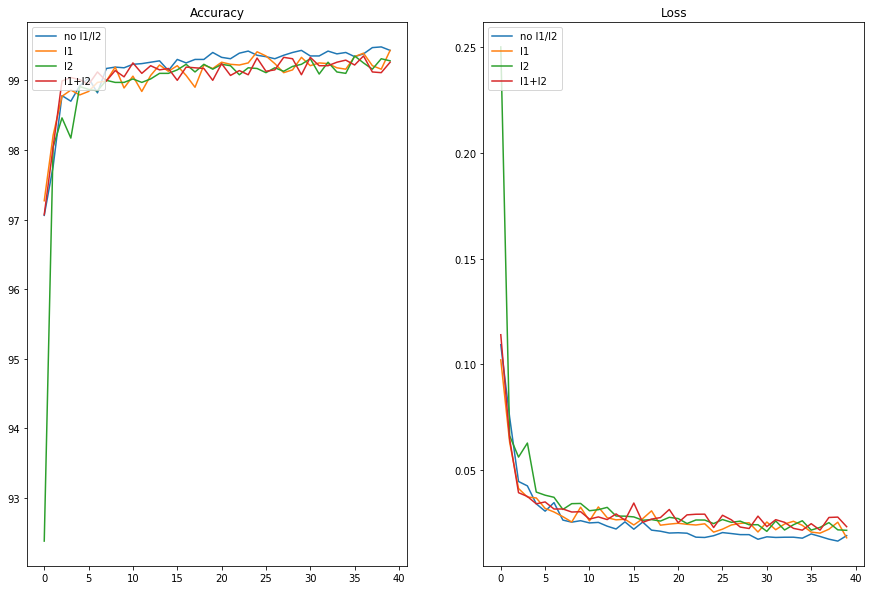

In [21]:
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2,figsize=(15,10))
axs[0].plot(test_acc_normal, label='no l1/l2')
axs[0].plot(test_acc_l1, label='l1')
axs[0].plot(test_acc_l2, label='l2')
axs[0].plot(test_acc_l1l2, label='l1+l2')
axs[0].set_title("Accuracy")
axs[0].legend(loc="upper left")

axs[1].plot(test_losses_normal,label='no l1/l2')
#axs[0, 1].set_title("Test Loss")
axs[1].plot(test_losses_l1,label='l1')
axs[1].plot(test_losses_l2,label='l2')
axs[1].plot(test_losses_l1l2,label='l1+l2')
axs[1].set_title("Loss")
axs[1].legend(loc="upper left")
#axs[1, 1].set_title("Test Accuracy")